In [51]:
# Installation des bibliothèques nécessaires
# pip install requests pandas numpy scikit-learn xgboost matplotlib seaborn

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import time

In [23]:
dataset = pd.read_csv('EPL.csv')
dataset.head()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Fouls,A Fouls,H Corners,A Corners,H Yellow,A Yellow,H Red,A Red,Display_Order,League
0,16/01/2025,2024/25,Ipswich Town,Brighton & Hove Albion,0,2,A,0.0,1.0,A,...,13.0,14.0,1.0,9.0,2.0,2.0,0.0,0.0,20250116,Premier League
1,16/01/2025,2024/25,Man United,Southampton,3,1,H,0.0,1.0,A,...,7.0,10.0,4.0,4.0,1.0,3.0,0.0,0.0,20250116,Premier League
2,15/01/2025,2024/25,Everton,Aston Villa,0,1,A,0.0,0.0,D,...,17.0,10.0,8.0,5.0,2.0,1.0,0.0,0.0,20250115,Premier League
3,15/01/2025,2024/25,Leicester,Crystal Palace,0,2,A,0.0,0.0,D,...,7.0,6.0,4.0,3.0,0.0,0.0,0.0,0.0,20250115,Premier League
4,15/01/2025,2024/25,Newcastle,Wolves,3,0,H,1.0,0.0,H,...,10.0,13.0,4.0,2.0,0.0,2.0,0.0,0.0,20250115,Premier League


In [24]:
# Conversion de la colonne 'Date' en format datetime
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')

In [25]:
# On garde uniquement les matchs à partir de la saison 2018/2019
dataset = dataset[dataset['Date'] >= '01/08/2018']  
dataset = dataset[dataset['Date'] <= '31/05/2024']  # On garde jusqu'à la saison 2023/2024

In [26]:
dataset['FT Result'].unique()

array(['H', 'A', 'D'], dtype=object)

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2440 entries, 209 to 2648
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2440 non-null   datetime64[ns]
 1   Season         2440 non-null   object        
 2   HomeTeam       2440 non-null   object        
 3   AwayTeam       2440 non-null   object        
 4   FTH Goals      2440 non-null   int64         
 5   FTA Goals      2440 non-null   int64         
 6   FT Result      2440 non-null   object        
 7   HTH Goals      2440 non-null   float64       
 8   HTA Goals      2440 non-null   float64       
 9   HT Result      2440 non-null   object        
 10  Referee        2440 non-null   object        
 11  H Shots        2440 non-null   float64       
 12  A Shots        2440 non-null   float64       
 13  H SOT          2440 non-null   float64       
 14  A SOT          2440 non-null   float64       
 15  H Fouls        2440 non-

In [28]:
df_train = dataset[dataset['Date'] < '01/08/2023']
df_test = dataset[dataset['Date'] >= '01/08/2023']
print(f"Taille du dataset d'entraînement: {df_train.shape[0]} matchs")
print(f"Taille du dataset de test: {df_test.shape[0]} matchs")

Taille du dataset d'entraînement: 1856 matchs
Taille du dataset de test: 584 matchs


In [29]:
df_train['Day'] = df_train['Date'].dt.day
df_train['Month'] = df_train['Date'].dt.month
df_train['Year'] = df_train['Date'].dt.year
df_train['Weekday'] = df_train['Date'].dt.weekday  # Lundi=0, Dimanche=6

df_test['Day'] = df_test['Date'].dt.day
df_test['Month'] = df_test['Date'].dt.month
df_test['Year'] = df_test['Date'].dt.year
df_test['Weekday'] = df_test['Date'].dt.weekday


C:\Users\Nitropc\AppData\Local\Temp\ipykernel_7932\450495696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Day'] = df_train['Date'].dt.day
C:\Users\Nitropc\AppData\Local\Temp\ipykernel_7932\450495696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Month'] = df_train['Date'].dt.month
C:\Users\Nitropc\AppData\Local\Temp\ipykernel_7932\450495696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [30]:
df_test.head()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Yellow,A Yellow,H Red,A Red,Display_Order,League,Day,Month,Year,Weekday
209,2024-05-19,2023/24,Chelsea,Bournemouth,2,1,H,1.0,0.0,H,...,2.0,3.0,0.0,0.0,20240519,Premier League,19,5,2024,6
210,2024-05-19,2023/24,Brighton,Man United,0,2,A,0.0,0.0,D,...,1.0,3.0,0.0,0.0,20240519,Premier League,19,5,2024,6
211,2024-05-19,2023/24,Crystal Palace,Aston Villa,5,0,H,2.0,0.0,H,...,1.0,4.0,0.0,0.0,20240519,Premier League,19,5,2024,6
212,2024-05-19,2023/24,Arsenal,Everton,2,1,H,1.0,1.0,D,...,4.0,3.0,0.0,0.0,20240519,Premier League,19,5,2024,6
213,2024-05-19,2023/24,Sheffield United,Tottenham,0,3,A,0.0,1.0,A,...,2.0,0.0,0.0,0.0,20240519,Premier League,19,5,2024,6


In [31]:
# On crée un DataFrame avec tous les matchs du point de vue de l'équipe concernée
def build_team_form_df(df):
    home = df[['Date', 'HomeTeam', 'AwayTeam', 'FT Result']].copy()
    home['Team'] = home['HomeTeam']
    home['Opponent'] = home['AwayTeam']
    home['Home'] = 1
    home['Result'] = home['FT Result'].map({'H': 3, 'D': 1, 'A': 0})

    away = df[['Date', 'HomeTeam', 'AwayTeam', 'FT Result']].copy()
    away['Team'] = away['AwayTeam']
    away['Opponent'] = away['HomeTeam']
    away['Home'] = 0
    away['Result'] = away['FT Result'].map({'A': 3, 'D': 1, 'H': 0})

    team_matches = pd.concat([home, away], axis=0)
    team_matches = team_matches[['Date', 'Team', 'Opponent', 'Home', 'Result']]
    team_matches = team_matches.sort_values(by='Date')

    return team_matches.reset_index(drop=True)


In [32]:
def add_form_score(df_matches, window=5):
    df_matches['Form_Points'] = (
        df_matches.groupby('Team')['Result']
        .apply(lambda x: x.shift().rolling(window=window).sum())
        .reset_index(level=0, drop=True)
    )
    return df_matches


In [33]:
def merge_form_features(df_base, df_form):
    # Home team
    home_form = df_form[['Date', 'Team', 'Form_Points']].rename(
        columns={'Team': 'HomeTeam', 'Form_Points': 'HomeForm'}
    )
    df_base = df_base.merge(home_form, on=['Date', 'HomeTeam'], how='left')

    # Away team
    away_form = df_form[['Date', 'Team', 'Form_Points']].rename(
        columns={'Team': 'AwayTeam', 'Form_Points': 'AwayForm'}
    )
    df_base = df_base.merge(away_form, on=['Date', 'AwayTeam'], how='left')

    return df_base


In [34]:
df_all = pd.concat([df_train, df_test])  # Important pour avoir historique complet
df_form = build_team_form_df(df_all)
df_form = add_form_score(df_form, window=5)

df_train = merge_form_features(df_train, df_form)
df_test = merge_form_features(df_test, df_form)


In [35]:
df_train_encoded = pd.get_dummies(df_train, columns=['HomeTeam', 'AwayTeam'])
df_test_encoded = pd.get_dummies(df_test, columns=['HomeTeam', 'AwayTeam'])

In [36]:
df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='left', axis=1, fill_value=0)

In [37]:
print(df_train_encoded.shape)
print(df_test_encoded.shape)

(1856, 87)
(584, 87)


In [38]:
columns_to_drop = ['FTH Goals', 'FTA Goals',
                   'HTH Goals', 'HTA Goals', 'HT Result', 
                   'Display_Order', 'Referee', 'League',
                    'A Corners', 'Day', 'Year', 'Weekday',
                    'H Fouls', 'A Fouls', 'Month', 'A Yellow']

In [39]:
# Sélectionner les features (sans les variables cibles)
X_train = df_train_encoded.drop(columns=columns_to_drop)
X_test = df_test_encoded.drop(columns=columns_to_drop)

In [40]:
# Filtrage des données
train_no_draw = X_train[df_train_encoded['FT Result'] != 'D']
test_no_draw = X_test[df_test_encoded['FT Result'] != 'D']


In [41]:
X_train = train_no_draw.drop(columns=['FT Result', 'Date', 'Season'], errors='ignore')
y_train = train_no_draw['FT Result'].map({'H': 0, 'A': 1})

X_test = test_no_draw.drop(columns=['FT Result', 'Date', 'Season'], errors='ignore')
y_test = test_no_draw['FT Result'].map({'H': 0, 'A': 1})


In [42]:
# Entraîner votre modèle
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Évaluer votre modèle
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Précision du modèle: {accuracy:.4f}")

Précision du modèle: 0.7610


In [46]:
# Dictionnaire des paramètres à tester
params = {
    'max_depth': [1,2,3,4,5],
    'learning_rate': [0.0625,0.075,0.0875,0.1,0.125],
    'n_estimators': [75,90,100,150,200],
    'subsample': [0.2,0.3,0.4,0.5,0.6]
}

# Initialisation du modèle
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)

# Grid search avec validation croisée (cv=3)
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # utilise tous les cœurs disponibles pour aller plus vite
)

# Pour mesurer le temps d'exécution
start = time.time()
grid.fit(X_train, y_train)
end = time.time()

# Résultats
print("✅ Best parameters found:", grid.best_params_)
print(f"🎯 Best CV accuracy: {grid.best_score_:.4f}")
print(f"⏱️ Temps d'entraînement: {end - start:.1f} secondes")

Fitting 3 folds for each of 625 candidates, totalling 1875 fits
✅ Best parameters found: {'learning_rate': 0.075, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.5}
🎯 Best CV accuracy: 0.7987
⏱️ Temps d'entraînement: 7.3 secondes


In [47]:
best_model = grid.best_estimator_
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"📊 Précision sur le test final : {accuracy:.4f}")

📊 Précision sur le test final : 0.7873


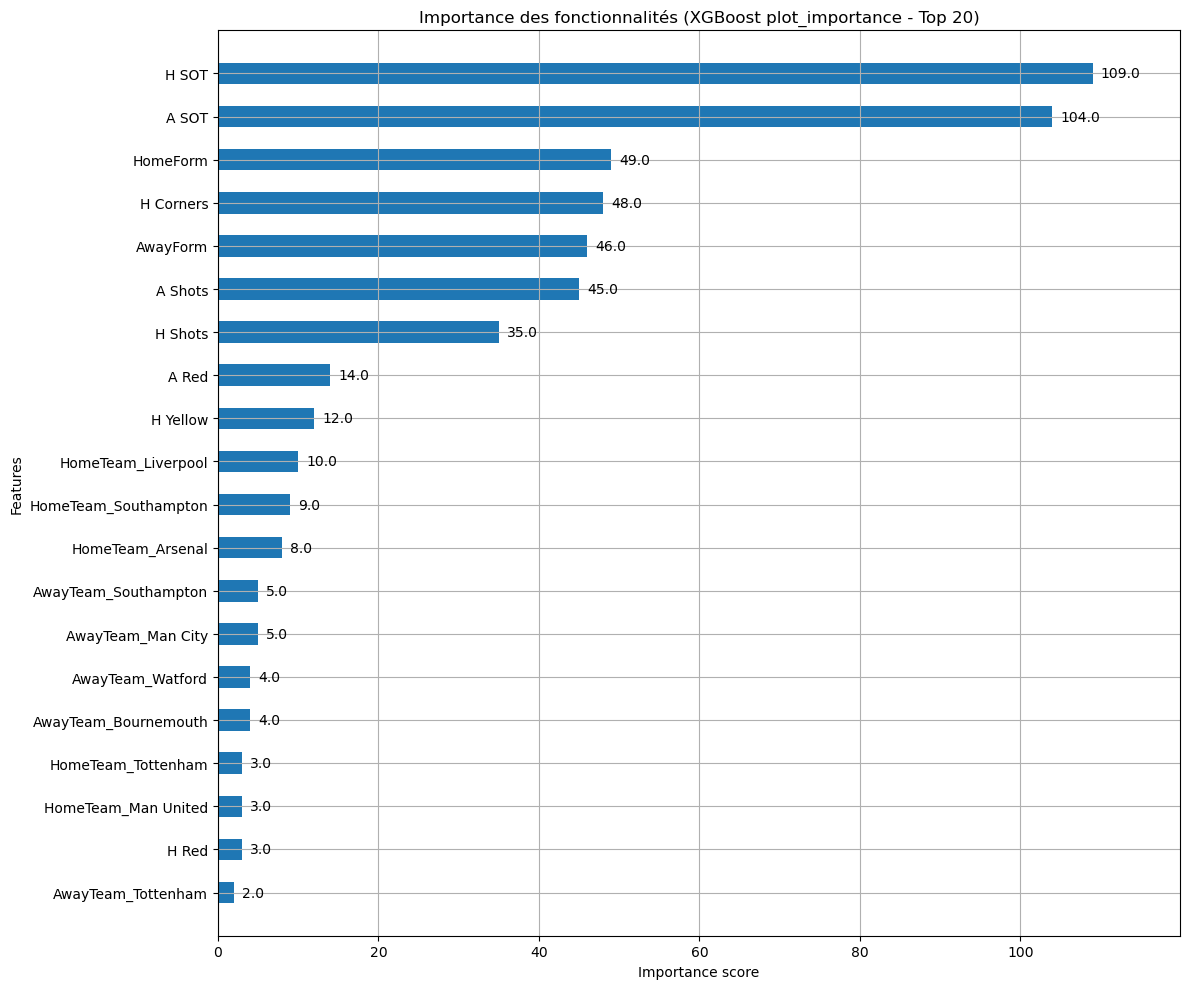


Importance des fonctionnalités (scores numériques) :
                    feature  importance
0                     H SOT    0.068747
1                     A SOT    0.068414
2      AwayTeam_Aston Villa    0.037199
3        AwayTeam_Liverpool    0.036891
4      HomeTeam_Aston Villa    0.032680
5         AwayTeam_Man City    0.032125
6        AwayTeam_Leicester    0.030229
7      HomeTeam_Southampton    0.030070
8          HomeTeam_Arsenal    0.029814
9      AwayTeam_Bournemouth    0.029374
10          AwayTeam_Fulham    0.027796
11         AwayTeam_Chelsea    0.027154
12         HomeTeam_Norwich    0.026470
13                 AwayForm    0.025962
14  AwayTeam_Crystal Palace    0.024513
15      AwayTeam_Man United    0.024469
16        HomeTeam_Brighton    0.024433
17                    A Red    0.024267
18       HomeTeam_Liverpool    0.023671
19         AwayTeam_Everton    0.023242


C:\Users\Nitropc\AppData\Local\Temp\ipykernel_7932\3121488333.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_feature_importance.head(20), palette='viridis')


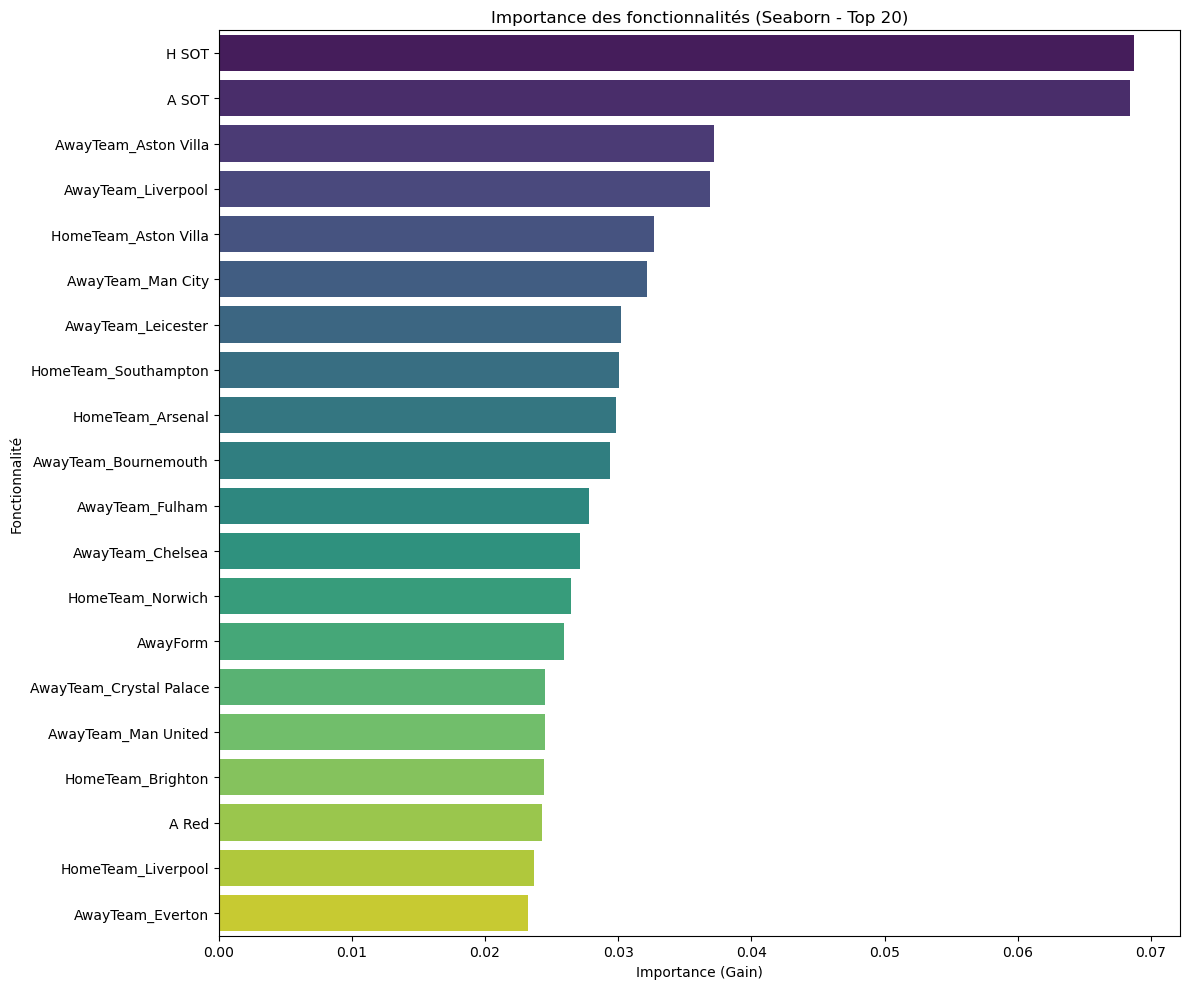

In [54]:
# Méthode 1: Utiliser la fonction plot_importance de XGBoost
# Elle utilise par défaut les noms "f0", "f1", etc., si les noms de fonctionnalités
# ne sont pas directement intégrés au modèle d'une manière qu'elle reconnaît.
# Pour afficher plus de fonctionnalités, augmentez max_num_features.
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(best_model, ax=ax, max_num_features=20, height=0.5, title="Importance des fonctionnalités (XGBoost plot_importance - Top 20)")
plt.tight_layout()
plt.show()

# Méthode 2: Créer un DataFrame d'importance pour un graphique personnalisé avec Seaborn
# Cela nous donne plus de contrôle et permet d'utiliser les vrais noms de fonctionnalités de X_train.

# Récupérer les noms de fonctionnalités de X_train (utilisé pour entraîner le modèle)
# X_train est défini à la cellule 41
feature_names = X_train.columns
importances = best_model.feature_importances_

df_feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("\nImportance des fonctionnalités (scores numériques) :")
print(df_feature_importance.head(20))

# Visualisation avec Seaborn
plt.figure(figsize=(12, 10)) # Ajuster la taille pour une meilleure lisibilité
sns.barplot(x='importance', y='feature', data=df_feature_importance.head(20), palette='viridis')
plt.title('Importance des fonctionnalités (Seaborn - Top 20)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Fonctionnalité')
plt.tight_layout()
plt.show()

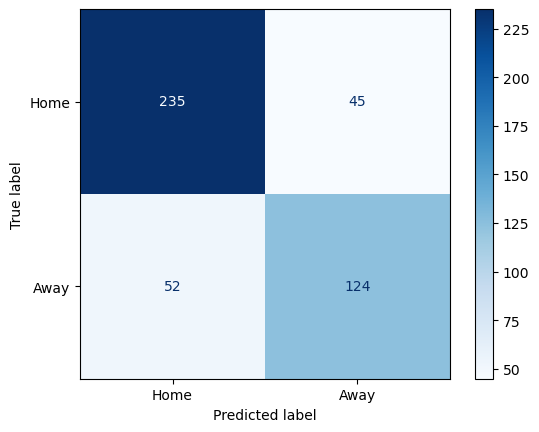

In [48]:
# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home','Away'])
disp.plot(cmap='Blues')

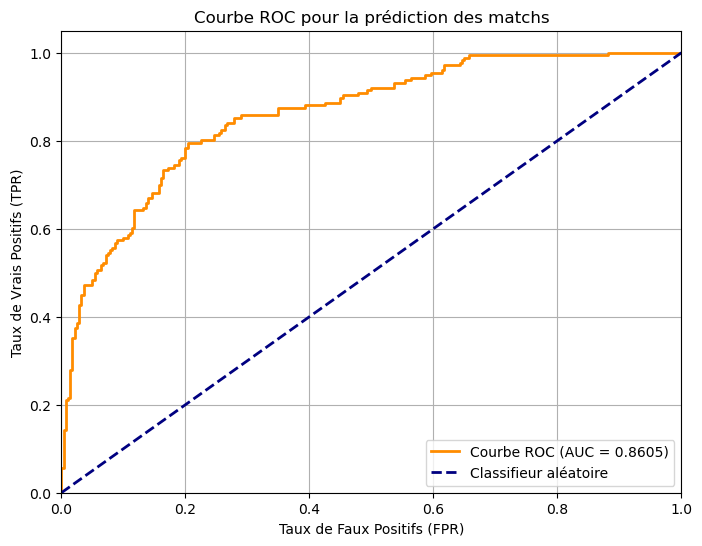

Score AUC calculé : 0.8605


In [52]:
# Obtenir les probabilités prédites pour la classe positive (Away win, label 1)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer le FPR, TPR, et les seuils pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)
# Alternativement, vous pouvez utiliser roc_auc_score directement :
# roc_auc_direct = roc_auc_score(y_test, y_pred_proba)
# print(f"Score AUC (calculé directement): {roc_auc_direct:.4f}")


# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classifieur aléatoire')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC pour la prédiction des matchs')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Score AUC calculé : {roc_auc:.4f}")

Comment interpréter la courbe ROC et l'AUC :

La courbe : Plus la courbe ROC s'éloigne de la diagonale et se rapproche du coin supérieur gauche du graphique, meilleure est la performance du modèle. Une courbe dans le coin supérieur gauche indique un TPR élevé et un FPR faible.


L'AUC :
Un score AUC supérieur à 0.80 signifie que le modèle a une excellente capacité à distinguer entre les victoires à domicile et les victoires à l'extérieur.